# Musculoskeletal Radiographs abnormality detection

# GROUP 17 (Sec: 1)
- Kinjal Bhatt : 0773192
- Parneet Kaur : 0775610
- Jaykumar Patel : 0774878
- Uttaran Gangopadhyay : 0768780

### Import required library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Input, UpSampling2D
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [ ]:
#Linking Colab Notebook to the Module
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

your_module = drive.CreateFile({'id':'1azKZ5yCbfpSXN0IU4N_Yg6_8BuxSNgUE'})
your_module.GetContentFile('DataLoad.py')
import DataLoad

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

### Loading Elbow data

In [ ]:
train_path = '/content/drive/MyDrive/MURA-v1.1/train_image_paths.csv'
valid_path = '/content/drive/MyDrive/MURA-v1.1/valid_image_paths.csv'
body_part = 'XR_ELBOW'

train,valid = DataLoad.data_load(train_path, valid_path, body_part) 

### Load Labels

In [ ]:
train_labels= DataLoad.labels(train)
valid_labels = DataLoad.labels(valid)

## EDA

### Check Positive and negative image

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


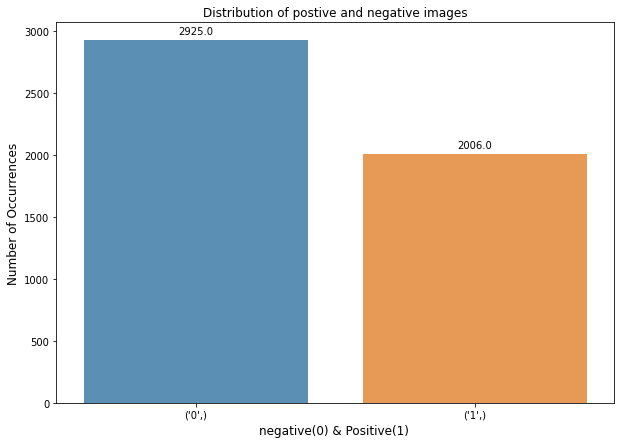

In [ ]:
cases_count = pd.DataFrame(train_labels).value_counts() # Image distribution in training data
plt.figure(figsize=(10,7))
splot = sns.barplot(cases_count.index.to_flat_index(), cases_count.values, alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Distribution of postive and negative images')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('negative(0) & Positive(1) ', fontsize=12)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


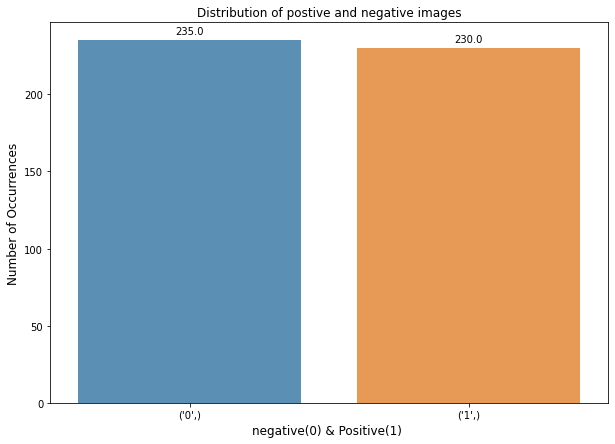

In [ ]:
cases_count = pd.DataFrame(valid_labels).value_counts() # Image distribution in Validation data
plt.figure(figsize=(10,7))
splot = sns.barplot(cases_count.index.to_flat_index(), cases_count.values, alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Distribution of postive and negative images')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('negative(0) & Positive(1) ', fontsize=12)
plt.show()

### Display some pictures

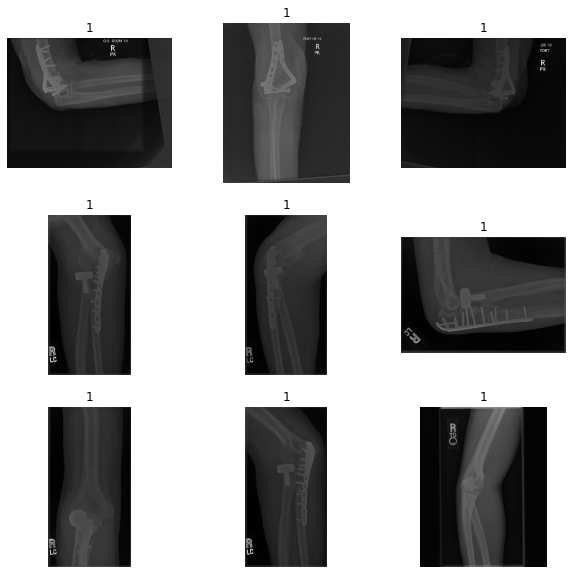

In [ ]:
import matplotlib.image as img
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  image = img.imread(valid[i])
  plt.imshow(image, cmap='gray')
  plt.title(valid_labels[i])
  plt.axis("off")

## Data Loading 

In [ ]:
def load_images(location, labels):
  images = []
  for image_path in location:
    image  = keras.preprocessing.image.load_img(image_path, color_mode= 'rgb', target_size = (177, 224))
    input_arr = np.array(image)
    input_arr = img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    images.append(input_arr)
  image_array = np.array(images)
  image_label = keras.utils.to_categorical(labels)
  return images, image_array, image_label

train_image, x_train, y_train = load_images(train,train_labels) 
valid_image, x_valid, y_valid = load_images(valid,valid_labels) 

In [ ]:
x_train.shape, y_train.shape,x_valid.shape,y_valid.shape

((4931, 1, 177, 224, 3), (4931, 2), (465, 1, 177, 224, 3), (465, 2))

### Reshape the data

In [ ]:
x_train = x_train.astype('float32') / 255 - 0.5
x_train = x_train.reshape((4931 , 177 , 224, 3))

x_valid = x_valid.astype('float32') / 255 - 0.5
x_valid = x_valid.reshape((465, 177 , 224, 3))

### Saving the load data as numpy array
- In this part we are saving train and validation image data as numpy file. So later on we can load it and our data get loaded without taking much time.

In [ ]:
np.save('/content/drive/MyDrive/MURA-v1.1/x_train', x_train)
np.save('/content/drive/MyDrive/MURA-v1.1/y_train', y_train)
np.save('/content/drive/MyDrive/MURA-v1.1/x_valid', x_valid)
np.save('/content/drive/MyDrive/MURA-v1.1/y_valid', y_valid)

### Loading stored numpy array 

In [ ]:
%%time

x_train = np.load('/content/drive/MyDrive/MURA-v1.1/x_train.npy')
y_train = np.load('/content/drive/MyDrive/MURA-v1.1/y_train.npy')
x_valid = np.load('/content/drive/MyDrive/MURA-v1.1/x_valid.npy')
y_valid = np.load('/content/drive/MyDrive/MURA-v1.1/y_valid.npy')



CPU times: user 129 ms, sys: 2.87 s, total: 3 s
Wall time: 11.1 s


In [ ]:
x_train.shape

(4931, 177, 224, 3)

## Modelling

### Creating Densenet169

In [ ]:
callback = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/MURA-v1.1/Model/DenseNet169.keras",
                                            save_best_only=True,
                                            monitor="val_loss")

opt = Adam(
    
)
from keras.applications.densenet import DenseNet169
dense_model = DenseNet169(include_top=True , 
                          weights=None,
                          input_shape = (  177 , 224, 3),
                          classes=2)

dense_model.compile(loss='categorical_crossentropy', optimizer= opt, 
                    metrics=['accuracy'])

#dense_model.summary()

history = dense_model.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=128, verbose=1, callbacks=[callback])

Epoch 1/5
31/31 [==============================] - 356s 11s/step - loss: 0.8138 - accuracy: 0.5783 - val_loss: 1.0003 - val_accuracy: 0.0000e+00
Epoch 2/5
31/31 [==============================] - 336s 11s/step - loss: 0.6554 - accuracy: 0.6212 - val_loss: 0.5053 - val_accuracy: 0.8460
Epoch 3/5
31/31 [==============================] - 337s 11s/step - loss: 0.6323 - accuracy: 0.6445 - val_loss: 0.2465 - val_accuracy: 1.0000
Epoch 4/5
31/31 [==============================] - 332s 11s/step - loss: 0.6242 - accuracy: 0.6506 - val_loss: 0.3795 - val_accuracy: 1.0000
Epoch 5/5
31/31 [==============================] - 331s 11s/step - loss: 0.6333 - accuracy: 0.6673 - val_loss: 2.2732 - val_accuracy: 0.0709


In [ ]:
DenseNet169 = keras.models.load_model('/content/drive/MyDrive/MURA-v1.1/Model/DenseNet169.keras')
#new_model.summary()
loss,acc = DenseNet169.evaluate(x_valid, y_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 15s 823ms/step - loss: 0.8768 - accuracy: 0.5054
Accuracy is 50.53763389587402


### Plot the graph for accuracy 

In [ ]:
# Plot the graph for accuracy and loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout( )
plt.show()

### CNN 

In [ ]:
# callback_3 = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/MURA-v1.1/Model/CNN_1.h5",
#                                             save_best_only=True,
#                                             monitor="val_loss")

opt = Adam(
    # learning_rate= 1e-10
)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(177,224,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

# model.add(BatchNormalization(momentum=0.8))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(BatchNormalization(momentum=0.8))
# model.add(Dropout(0.4))

model.add(layers.Flatten())
model.add(Dense(units= 1024 , activation='relu'))
model.add(Dense(units= 512 , activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the network 
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model.summary()

history2 = model.fit(x_train, y_train, validation_split = 0.2 , epochs=200, batch_size=64, verbose=1) #callbacks = [callback_3]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 177, 224, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 88, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 88, 112, 32)       9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 44, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 44, 56, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 22, 28, 32)      

In [ ]:
model.save('/content/drive/MyDrive/MURA-v1.1/Model/Simple_CNN.h5')
loss,acc = model.evaluate(x_valid, y_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 1s 63ms/step - loss: 2.7814 - accuracy: 0.6430
Accuracy is 64.30107355117798


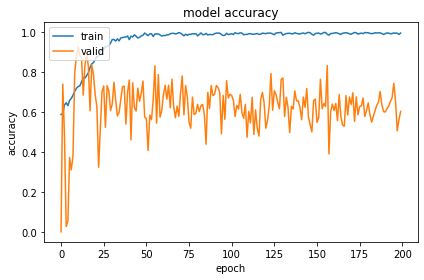

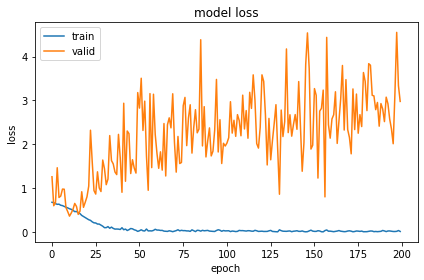

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.tight_layout( )
plt.show()

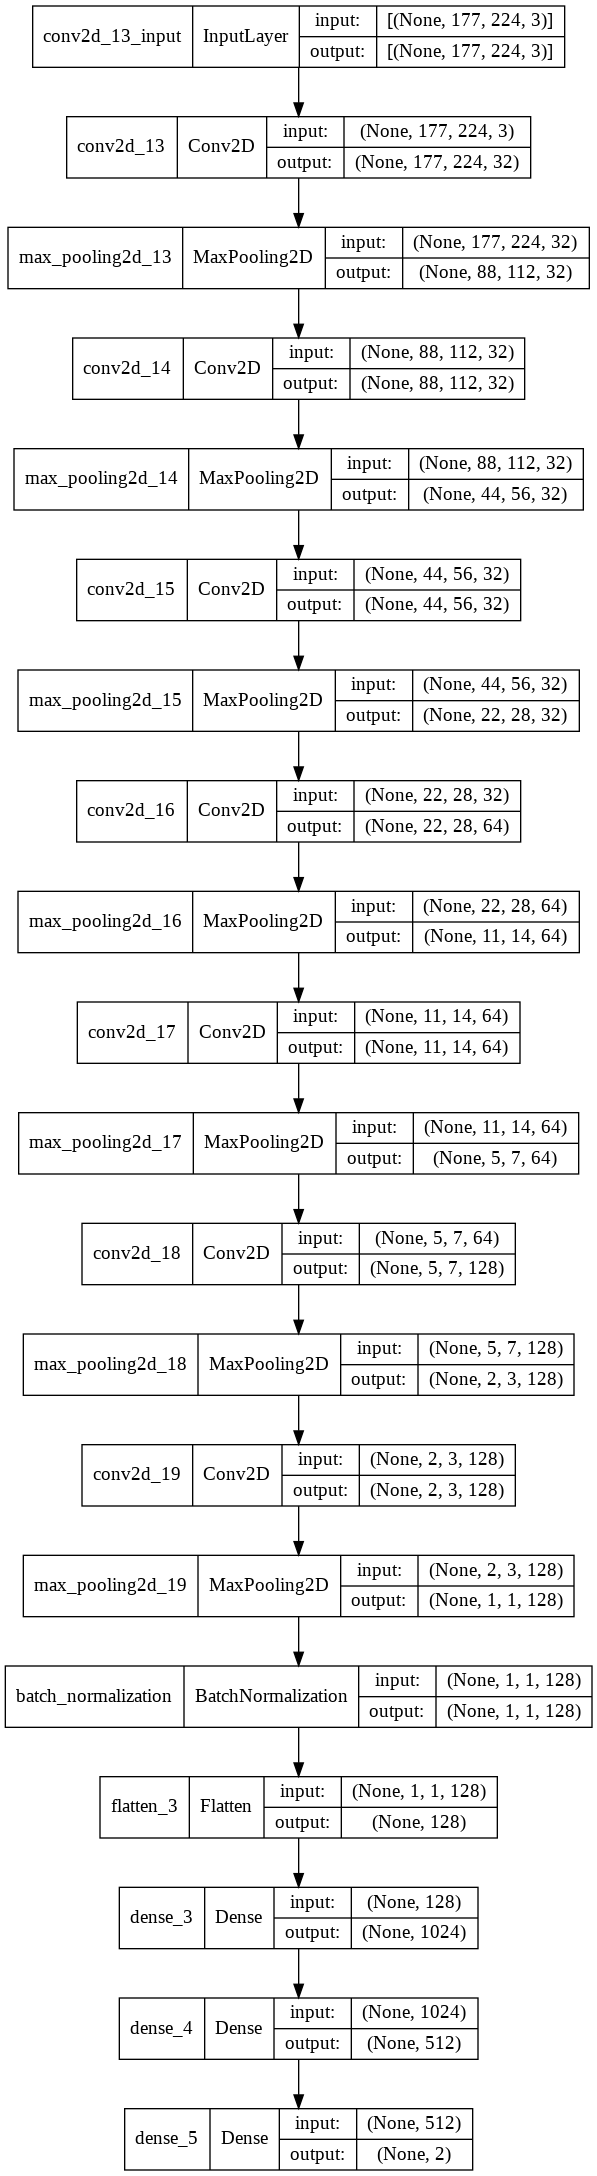

In [ ]:
keras.utils.plot_model(model,  to_file='/content/drive/MyDrive/MURA-v1.1/Model/Simple_CNN.png', show_shapes=True)

In [ ]:
from tensorflow.keras import regularizers
# callback_3 = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/MURA-v1.1/Model/CNN.keras",
#                                             save_best_only=True,
#                                             monitor="val_loss")

opt = Adam(
    # learning_rate= 1e-3
)

input_img = keras.Input(shape=(177,224,3))

x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(input_img)
x = layers.BatchNormalization(momentum = 0.8)(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Flatten()(x)
x = layers.Dense(units= 1024 , activation='relu')(x)
x = layers.Dense(units= 512 , activation='relu')(x)
# x = layers.Dense(units= 256 , activation='relu')(x)
Output = layers.Dense(units= 2 , activation='softmax')(x)

CNN = keras.Model(input_img, Output)

# Compile the network 
CNN.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
CNN.summary()

history2 = CNN.fit(x_train, y_train, validation_split = 0.2 , epochs=150, batch_size=64, verbose=1) #callbacks = [callback_3]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 177, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 177, 224, 32)      416       
                                                                 
 batch_normalization (BatchN  (None, 177, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 177, 224, 32)      4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 112, 32)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 89, 112, 32)       4128

In [ ]:
CNN_1 = keras.models.load_model('/content/drive/MyDrive/MURA-v1.1/Model/CNN.h5')
loss,acc = CNN_1.evaluate(x_valid, y_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 2s 112ms/step - loss: 5.2623 - accuracy: 0.6710
Accuracy is 67.09677577018738


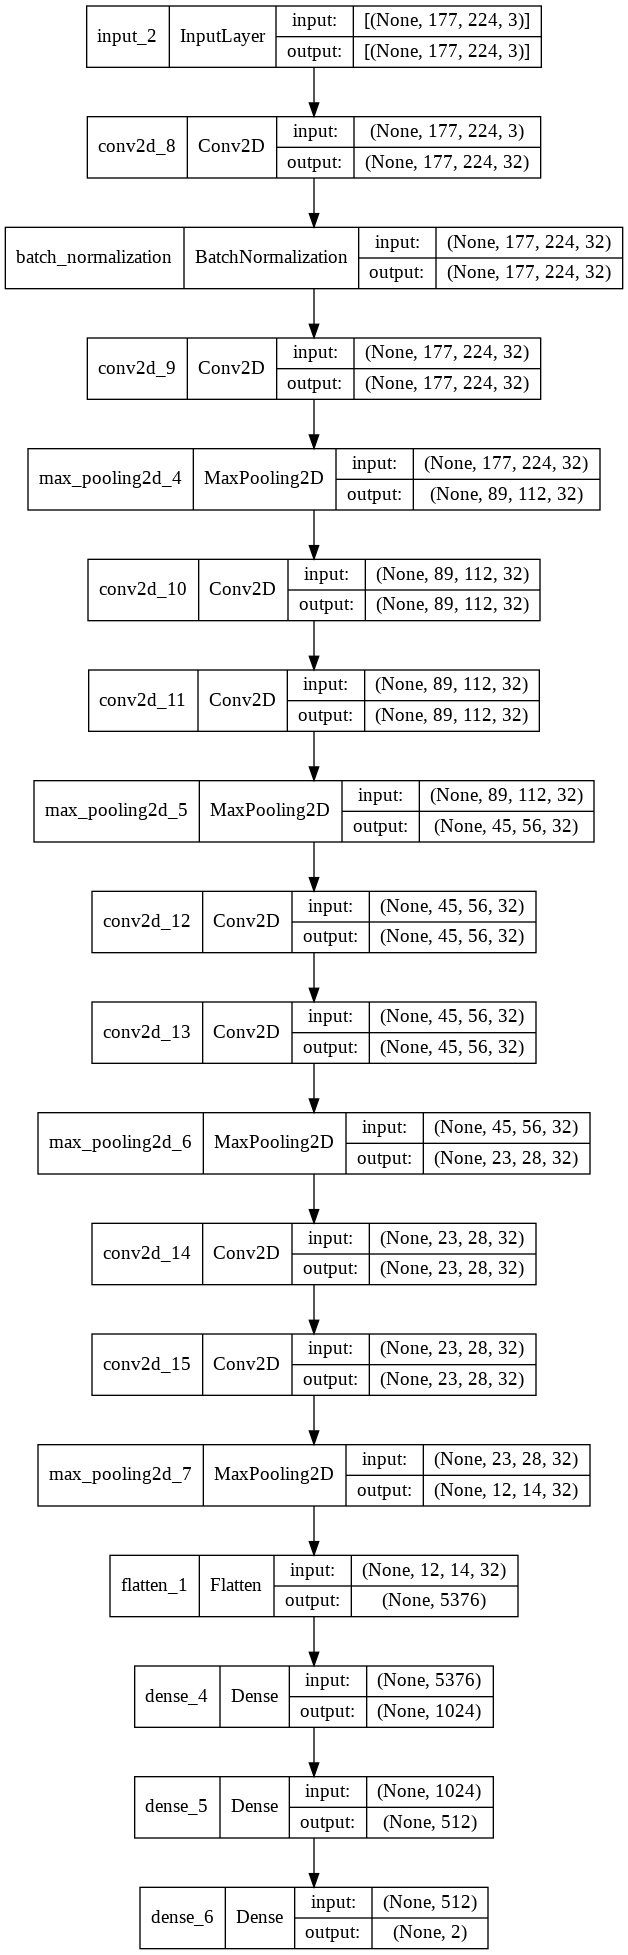

In [ ]:
keras.utils.plot_model(CNN_1,  to_file='/content/drive/MyDrive/MURA-v1.1/Model/Simple_CNN_2.png', show_shapes=True)

In [ ]:
loss,acc = CNN.evaluate(x_valid, y_valid)
print(f'Accuracy is {100*acc}')
CNN.save('/content/drive/MyDrive/MURA-v1.1/Model/CNN.h5')




---



### CNN + LSTM

In [ ]:
callback_5 = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/MURA-v1.1/Model/CNN_LSTM.keras",
                                            save_best_only=True,
                                            monitor="val_loss")

opt = Adam(
    learning_rate= 1e-10
)

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(177,224,3), padding= 'same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization(momentum=0.8))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer='l1'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding= 'same', activation='relu', kernel_regularizer='l1'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Reshape((784,32)))
model.add(layers.LSTM(
    units=64
))
model.add(layers.RepeatVector(n=x_train.shape[1]))
model.add(layers.LSTM(units=64, return_sequences=True))

# model.add(Dropout(0.4))

model.add(layers.Flatten())

model.add(Dense(units= 1024 , activation='relu'))
model.add(Dense(units= 512 , activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the network 
model.compile(loss='categorical_crossentropy', optimizer= opt, metrics=['accuracy'])
model.summary()

history3 = model.fit(x_train, y_train, validation_split = 0.2 , epochs=15, batch_size=64, verbose=1, callbacks = [callback_5])

In [ ]:
CNN_LSTM_Model = keras.models.load_model('/content/drive/MyDrive/MURA-v1.1/Model/CNN_LSTM.keras')
#new_model.summary()
loss,acc = CNN_LSTM_Model.evaluate(x_valid, y_valid)
print(f'Accuracy is {100*acc}')



---



## Auto Encoder

In [ ]:
# callback_1 = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/MURA-v1.1/Model/Auto-enconder.keras",
#                                             save_best_only=True,
#                                             monitor="val_loss")

input_img = keras.Input(shape=(177,224,3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(20608)(x)
x = layers.Dense(1024)(x)
encoded = layers.Dense(512)(x)


x = layers.Dense(1024)(encoded)
x = layers.Dense(20608)(x)
x = layers.Reshape((23,28,32))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.BatchNormalization(momentum=0.8)(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder =  layers.Cropping2D(cropping=((7, 0), (0, 0)), data_format=None)(x)
autoencoder = keras.Model(input_img, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder.summary()

history5 = autoencoder.fit(x_train, x_train, validation_split = 0.2 , epochs=15, batch_size=64, verbose=1) #callbacks=[callback_1]

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 177, 224, 3)]     0         
                                                                 
 conv2d_145 (Conv2D)         (None, 177, 224, 32)      896       
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 89, 112, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_37 (Bat  (None, 89, 112, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_146 (Conv2D)         (None, 89, 112, 32)       9248      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 45, 56, 32)       0  

In [ ]:
autoencoder.save('/content/drive/MyDrive/MURA-v1.1/Model/autoencoder.h5')
loss,acc = autoencoder.evaluate(x_valid, x_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 5s 319ms/step - loss: -4.5278 - accuracy: 0.1836
Accuracy is 18.360036611557007


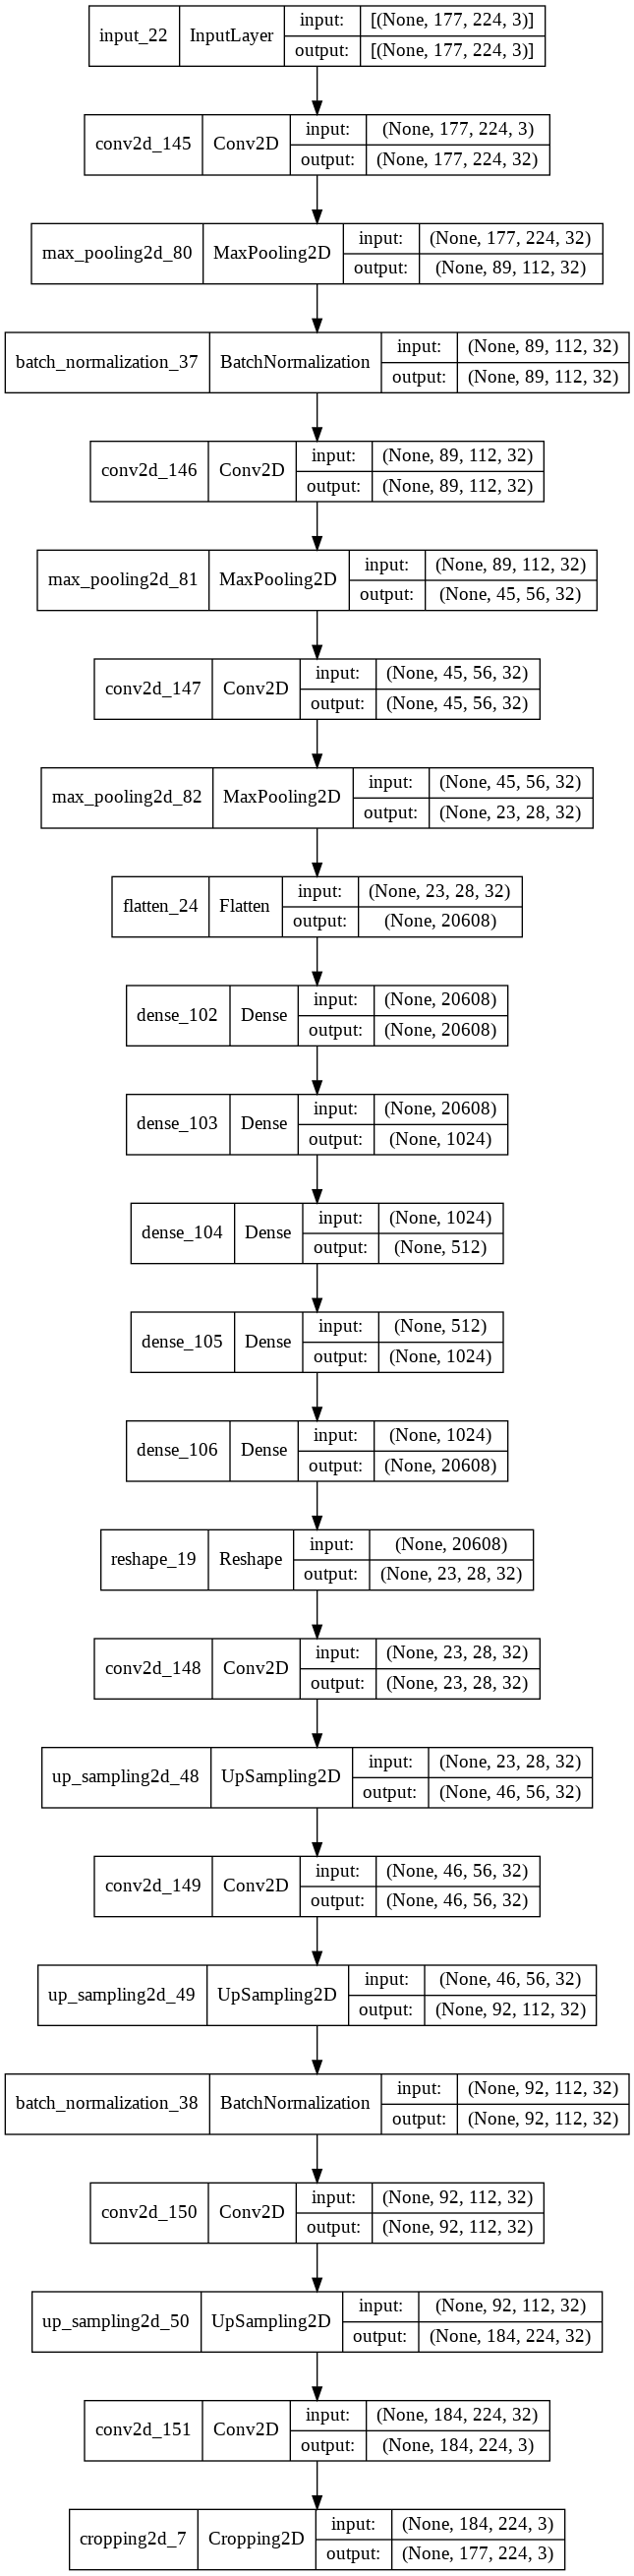

In [ ]:
keras.utils.plot_model(autoencoder,  to_file='/content/drive/MyDrive/MURA-v1.1/Model/autoencoder.png', show_shapes=True)

In [ ]:
history4 = autoencoder.fit(x_train, x_train, validation_split = 0.2 , epochs=15, batch_size=64, verbose=1)

Epoch 1/15
62/62 [==============================] - 165s 3s/step - loss: -4.5817 - accuracy: 0.1772 - val_loss: -4.7120 - val_accuracy: 0.1965
Epoch 2/15
62/62 [==============================] - 151s 2s/step - loss: -4.5823 - accuracy: 0.1837 - val_loss: -4.7118 - val_accuracy: 0.2076
Epoch 3/15
62/62 [==============================] - 154s 2s/step - loss: -4.5810 - accuracy: 0.1913 - val_loss: -4.7117 - val_accuracy: 0.1672
Epoch 4/15
62/62 [==============================] - 155s 3s/step - loss: -4.5820 - accuracy: 0.1908 - val_loss: -4.7118 - val_accuracy: 0.1745
Epoch 5/15
62/62 [==============================] - 155s 2s/step - loss: -4.5827 - accuracy: 0.2060 - val_loss: -4.7104 - val_accuracy: 0.2761
Epoch 6/15
62/62 [==============================] - 156s 3s/step - loss: -4.5814 - accuracy: 0.2149 - val_loss: -4.7124 - val_accuracy: 0.1991
Epoch 7/15
62/62 [==============================] - 154s 2s/step - loss: -4.5831 - accuracy: 0.2378 - val_loss: -4.7129 - val_accuracy: 0.2332

In [ ]:
loss,acc = autoencoder.evaluate(x_valid, x_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 5s 323ms/step - loss: -4.5297 - accuracy: 0.4968
Accuracy is 49.67724680900574


In [ ]:
autoencoder.save('/content/drive/MyDrive/MURA-v1.1/Model/autoencoder.h5')

In [ ]:
autoencoder = keras.models.load_model('/content/drive/MyDrive/MURA-v1.1/Model/autoencoder.h5')
#new_model.summary()
loss,acc = autoencoder.evaluate(x_valid, x_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 3s 146ms/step - loss: -4.5297 - accuracy: 0.4968
Accuracy is 49.67724680900574


In [ ]:
history5 = autoencoder.fit(x_train, x_train, validation_split = 0.2 , epochs=15, batch_size=64, verbose=1)

Epoch 1/15
62/62 [==============================] - 165s 3s/step - loss: -4.5840 - accuracy: 0.4896 - val_loss: -4.7128 - val_accuracy: 0.4954
Epoch 2/15
62/62 [==============================] - 156s 3s/step - loss: -4.5855 - accuracy: 0.4938 - val_loss: -4.7129 - val_accuracy: 0.6069
Epoch 3/15
62/62 [==============================] - 157s 3s/step - loss: -4.5851 - accuracy: 0.5348 - val_loss: -4.7113 - val_accuracy: 0.6234
Epoch 4/15
62/62 [==============================] - 158s 3s/step - loss: -4.5843 - accuracy: 0.5712 - val_loss: -4.7131 - val_accuracy: 0.6041
Epoch 5/15
62/62 [==============================] - 157s 3s/step - loss: -4.5851 - accuracy: 0.5737 - val_loss: -4.7133 - val_accuracy: 0.5843
Epoch 6/15
62/62 [==============================] - 157s 3s/step - loss: -4.5854 - accuracy: 0.5884 - val_loss: -4.7137 - val_accuracy: 0.6388
Epoch 7/15
62/62 [==============================] - 157s 3s/step - loss: -4.5858 - accuracy: 0.6011 - val_loss: -4.7129 - val_accuracy: 0.7509

In [ ]:
loss,acc = autoencoder.evaluate(x_valid, x_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 5s 323ms/step - loss: -4.5285 - accuracy: 0.7201
Accuracy is 72.01231718063354


In [ ]:
autoencoder.save('/content/drive/MyDrive/MURA-v1.1/Model/autoencoder.h5')

In [ ]:
history5 = autoencoder.fit(x_train, x_train, validation_split = 0.2 , epochs=5, batch_size=64, verbose=1)

Epoch 1/5
62/62 [==============================] - 165s 3s/step - loss: -4.5851 - accuracy: 0.7203 - val_loss: -4.7125 - val_accuracy: 0.7935
Epoch 2/5
62/62 [==============================] - 156s 3s/step - loss: -4.5843 - accuracy: 0.7164 - val_loss: -4.7133 - val_accuracy: 0.7589
Epoch 3/5
62/62 [==============================] - 156s 3s/step - loss: -4.5855 - accuracy: 0.7297 - val_loss: -4.7126 - val_accuracy: 0.7351
Epoch 4/5
62/62 [==============================] - 154s 2s/step - loss: -4.5865 - accuracy: 0.7219 - val_loss: -4.7137 - val_accuracy: 0.7676
Epoch 5/5
62/62 [==============================] - 157s 3s/step - loss: -4.5866 - accuracy: 0.7543 - val_loss: -4.7134 - val_accuracy: 0.7925


In [ ]:
loss,acc = autoencoder.evaluate(x_valid, x_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 5s 325ms/step - loss: -4.5285 - accuracy: 0.7758
Accuracy is 77.5761365890503


In [ ]:
autoencoder.save('/content/drive/MyDrive/MURA-v1.1/Model/autoencoder.h5')

In [ ]:
history6 = autoencoder.fit(x_train, x_train, validation_split = 0.2 , epochs=5, batch_size=64, verbose=1)

Epoch 1/5
62/62 [==============================] - 166s 3s/step - loss: -4.5864 - accuracy: 0.7159 - val_loss: -4.7131 - val_accuracy: 0.7827
Epoch 2/5
62/62 [==============================] - 158s 3s/step - loss: -4.5874 - accuracy: 0.7472 - val_loss: -4.7088 - val_accuracy: 0.7653
Epoch 3/5
62/62 [==============================] - 156s 3s/step - loss: -4.5866 - accuracy: 0.7266 - val_loss: -4.7129 - val_accuracy: 0.6982
Epoch 4/5
62/62 [==============================] - 157s 3s/step - loss: -4.5868 - accuracy: 0.7410 - val_loss: -4.7132 - val_accuracy: 0.7900
Epoch 5/5
62/62 [==============================] - 154s 2s/step - loss: -4.5858 - accuracy: 0.7302 - val_loss: -4.7121 - val_accuracy: 0.7442


In [ ]:
loss,acc = autoencoder.evaluate(x_valid, x_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 5s 323ms/step - loss: -4.5278 - accuracy: 0.7266
Accuracy is 72.66202569007874




---



---



---



# MSCNN 

In [ ]:
from keras.layers.merge import concatenate

# callback = keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/MURA-v1.1/Model/Auto-MSCNN1.keras",
#                                             save_best_only=True,
#                                             monitor="val_loss")

opt = Adam(
    # learning_rate= 1e-10
)

main_model = Sequential()
main_model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(177,224,3), strides=(1, 1), activation='relu'))
main_model.add(layers.MaxPool2D(pool_size=(2,2)))

main_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'))
main_model.add(layers.MaxPool2D(pool_size=(2,2)))
main_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'))
main_model.add(layers.MaxPool2D(pool_size=(2,2)))
main_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'))
main_model.add(layers.MaxPool2D(pool_size=(2,2)))
main_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'))
main_model.add(layers.MaxPool2D(pool_size=(2,2)))
# main_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), activation='relu'))
# main_model.add(layers.MaxPool2D(pool_size=(2,2)))
# main_model.add(layers.BatchNormalization(momentum=0.8))

main_model.add(layers.Flatten())

#lower features model - CNN2
lower_model1 = Sequential()
lower_model1.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(177,224,3),strides=(1, 1), activation='relu'))
lower_model1.add(layers.MaxPool2D(pool_size=(2,2)))
lower_model1.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu'))
lower_model1.add(layers.MaxPool2D(pool_size=(2,2)))
lower_model1.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu'))
lower_model1.add(layers.MaxPool2D(pool_size=(2,2)))
lower_model1.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1, 1), activation='relu'))
lower_model1.add(layers.MaxPool2D(pool_size=(2,2)))
# lower_model1.add(layers.BatchNormalization(momentum=0.8))
lower_model1.add(layers.Flatten())

#lower features model - CNN3
lower_model2 = Sequential()
lower_model2.add(Conv2D(filters=256, kernel_size=(3,3), input_shape=(177,224,3),strides=(1, 1), activation='relu'))
lower_model2.add(layers.MaxPool2D(pool_size=(2,2)))
lower_model2.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), activation='relu'))
lower_model2.add(layers.MaxPool2D(pool_size=(2,2)))
lower_model2.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), activation='relu'))
lower_model2.add(layers.MaxPool2D(pool_size=(2,2)))
lower_model2.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1, 1), activation='relu'))
lower_model2.add(layers.MaxPool2D(pool_size=(2,2)))
# lower_model2.add(layers.BatchNormalization(momentum=0.8))
lower_model2.add(layers.Flatten())


#merged model
merged_model = Model([main_model, lower_model1, lower_model2])

model_concat = concatenate([main_model.output, lower_model1.output,lower_model2.output], axis=-1)
model_concat = layers.Dense(units= 256 , activation='relu')(model_concat)
model_concat = layers.Dense(units= 128 , activation='relu')(model_concat)
model_concat = layers.Dense(2, activation='softmax')(model_concat)

final_model = Model(inputs=[main_model.input, lower_model1.input, lower_model2.input], outputs=model_concat)
          

final_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

final_model.summary()

history5 = final_model.fit([x_train, x_train, x_train], y_train, validation_split = 0.2 , epochs=10, batch_size=32, verbose=1) 

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_165_input (InputLayer)  [(None, 177, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_165 (Conv2D)            (None, 175, 222, 64  1792        ['conv2d_165_input[0][0]']       
                                )                                                                 
                                                                                                  
 max_pooling2d_96 (MaxPooling2D  (None, 87, 111, 64)  0          ['conv2d_165[0][0]']             
 )                                                                                         

In [ ]:
loss,acc = final_model.evaluate([x_valid, x_valid, x_valid], y_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 6s 415ms/step - loss: 0.7835 - accuracy: 0.6172
Accuracy is 61.720430850982666


In [ ]:
final_model.save('/content/drive/MyDrive/MURA-v1.1/Model/MSCNN.h5')


In [ ]:
history3 = final_model.fit([x_train, x_train, x_train], y_train, validation_split = 0.2 , epochs=30, batch_size=64, verbose=1)

Epoch 1/30
62/62 [==============================] - 291s 5s/step - loss: 0.4087 - accuracy: 0.7807 - val_loss: 1.2715 - val_accuracy: 0.5572
Epoch 2/30
62/62 [==============================] - 275s 4s/step - loss: 0.3289 - accuracy: 0.8283 - val_loss: 1.6860 - val_accuracy: 0.5674
Epoch 3/30
62/62 [==============================] - 276s 4s/step - loss: 0.2834 - accuracy: 0.8542 - val_loss: 1.5556 - val_accuracy: 0.5623
Epoch 4/30
62/62 [==============================] - 277s 4s/step - loss: 0.2682 - accuracy: 0.8737 - val_loss: 1.5950 - val_accuracy: 0.5694
Epoch 5/30
62/62 [==============================] - 278s 4s/step - loss: 0.2159 - accuracy: 0.9021 - val_loss: 2.2444 - val_accuracy: 0.6008
Epoch 6/30
62/62 [==============================] - 277s 4s/step - loss: 0.2123 - accuracy: 0.9087 - val_loss: 2.1866 - val_accuracy: 0.6059
Epoch 7/30
62/62 [==============================] - 278s 4s/step - loss: 0.1503 - accuracy: 0.9353 - val_loss: 2.7203 - val_accuracy: 0.5816
Epoch 8/30
62

In [ ]:
final_model.save('/content/drive/MyDrive/MURA-v1.1/Model/MSCNN_1.h5')

In [ ]:
Mscnn  = keras.models.load_model('/content/drive/MyDrive/MURA-v1.1/Model/MSCNN_1.h5')
#new_model.summary()


In [ ]:
loss,acc = Mscnn.evaluate([x_valid, x_valid, x_valid], x_valid)
print(f'Accuracy is {100*acc}')

NameError: ignored

In [ ]:
loss,acc = final_model.evaluate([x_valid, x_valid, x_valid], y_valid)
print(f'Accuracy is {100*acc}')

15/15 [==============================] - 7s 429ms/step - loss: 4.7713 - accuracy: 0.5957
Accuracy is 59.56989526748657


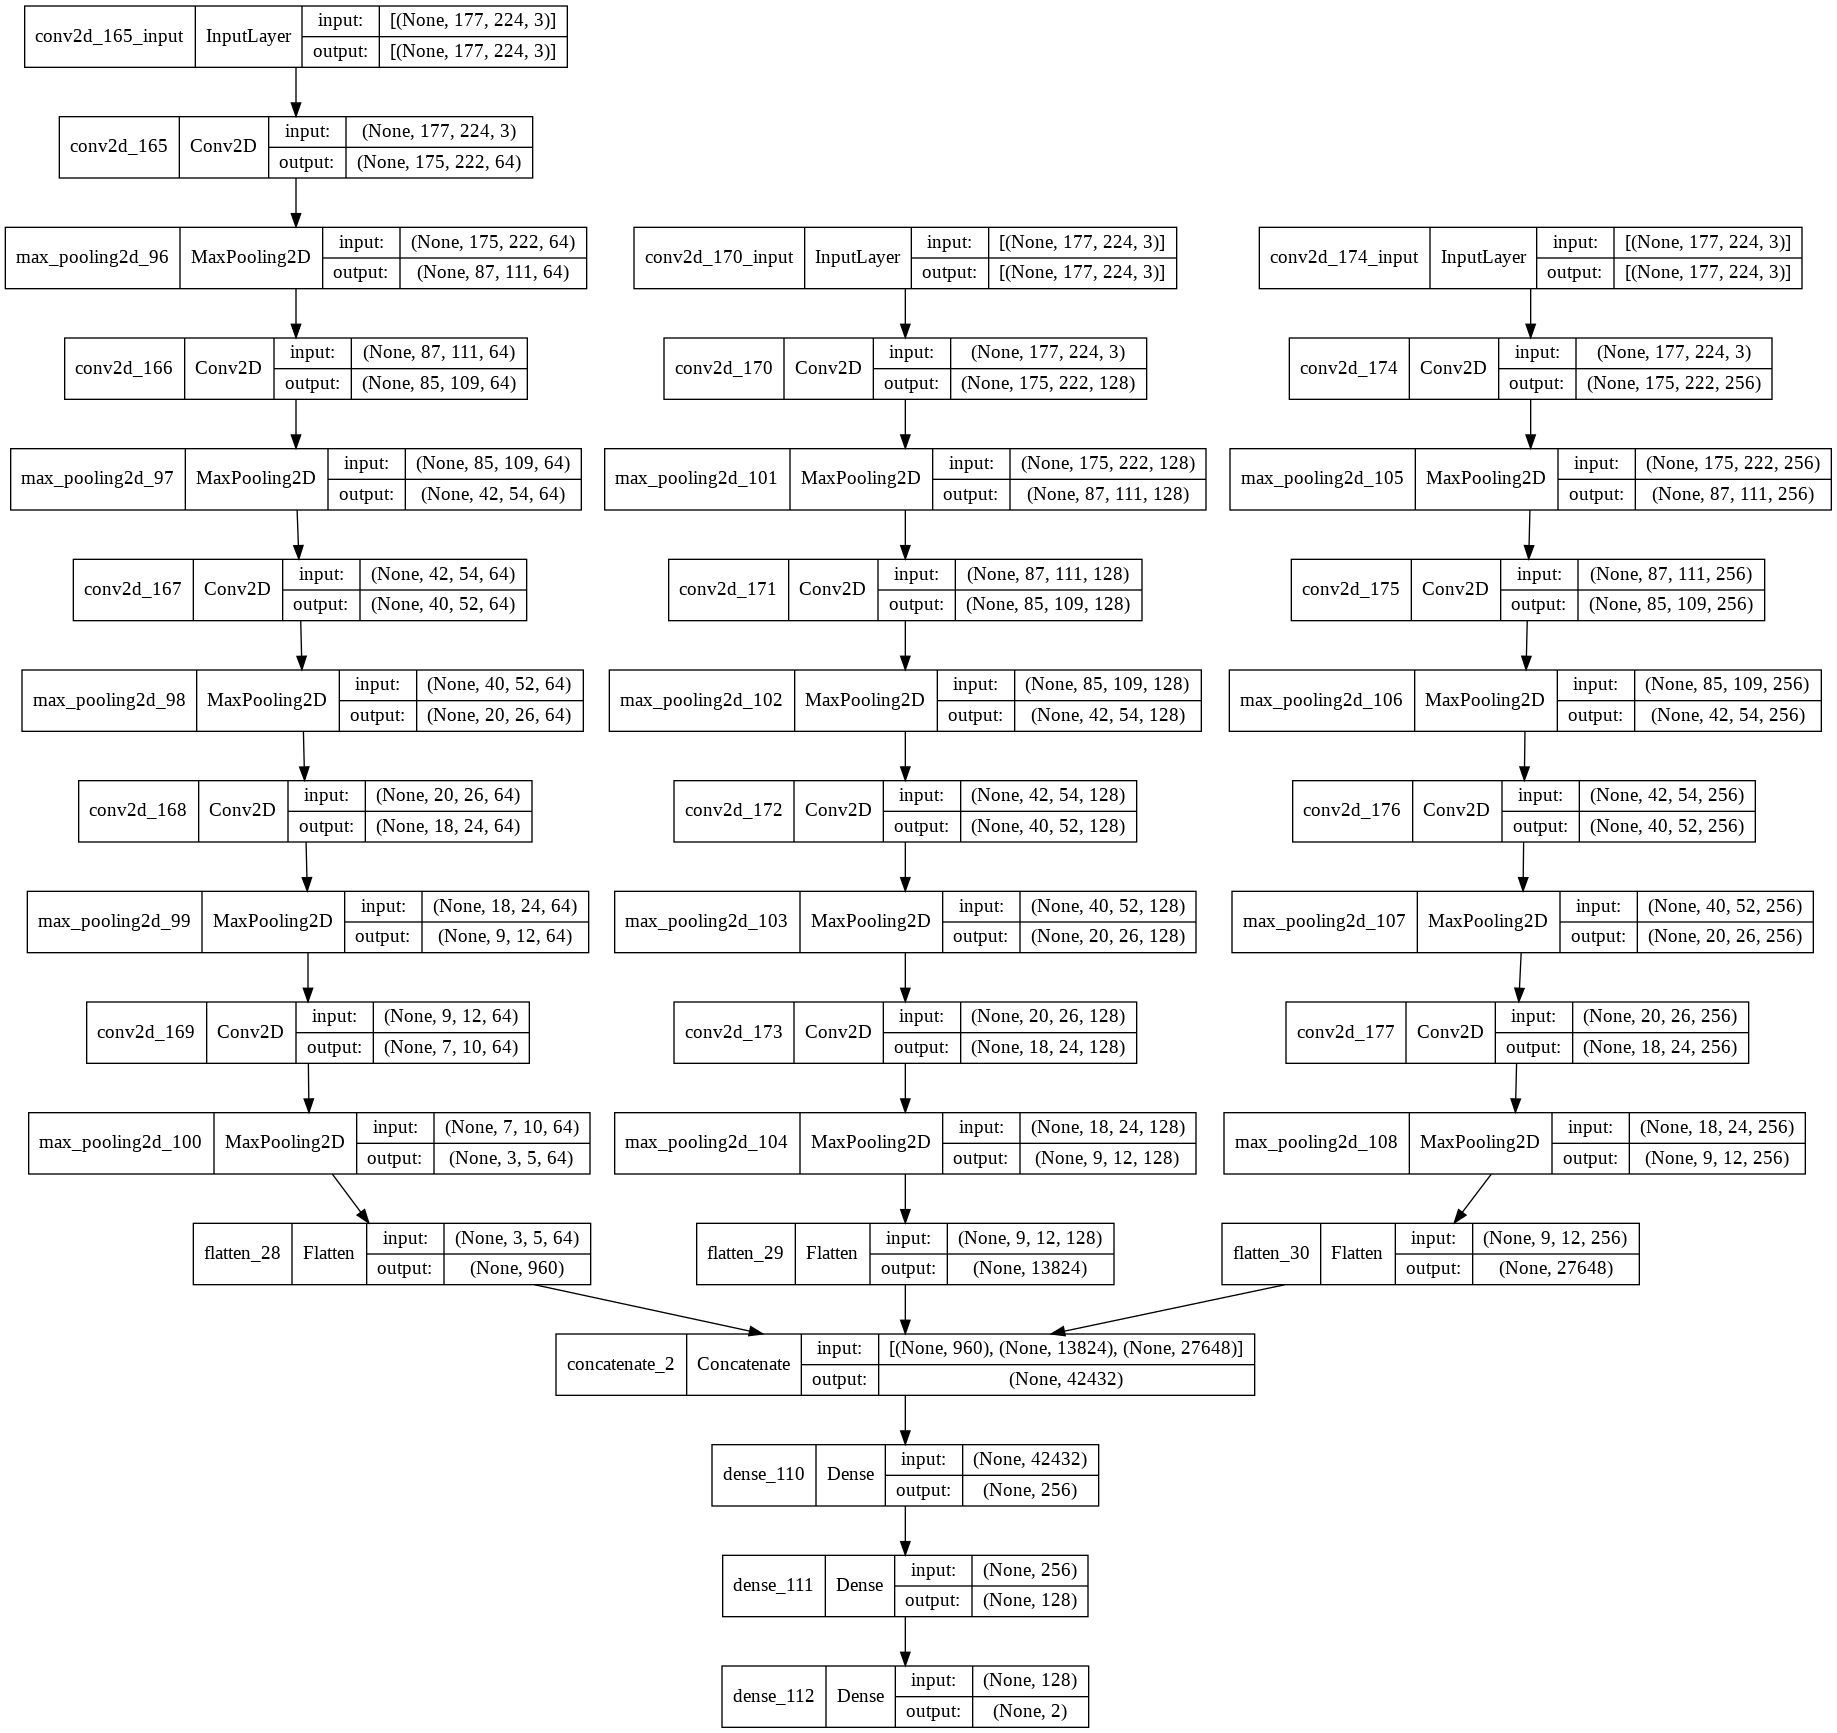

In [ ]:

keras.utils.plot_model(Mscnn,  to_file='/content/drive/MyDrive/MURA-v1.1/Model/Mscnn.png', show_shapes=True)

In [ ]:
loss,acc = CNN.evaluate(x_valid, y_valid)
print(f'Accuracy is {100*acc}')
CNN.save('/content/drive/MyDrive/MURA-v1.1/Model/CNN.h5')